## Shampoo Sales Dataset

            Sales
Date             
2000-01-01  266.0
2000-02-01  145.9
2000-03-01  183.1
2000-04-01  119.3
2000-05-01  180.3


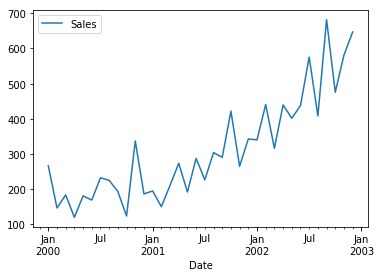

In [20]:
import pandas as pd
from matplotlib import pyplot as plt
 
def parser(x):
	return pd.to_datetime(x)
 
#series = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = pd.read_csv('shampoo-sales.csv', index_col=0, parse_dates=[0], date_parser=parser)
## Alternatively
## pd.to_datetime(series.index)     #if want to handle datetime conversion outside read_csv

print(series.head())
series.plot()
plt.show()

In [57]:
type(series)

pandas.core.frame.DataFrame

In [62]:
series.Sales

Date
2000-01-01    266.0
2000-02-01    145.9
2000-03-01    183.1
2000-04-01    119.3
2000-05-01    180.3
2000-06-01    168.5
2000-07-01    231.8
2000-08-01    224.5
2000-09-01    192.8
2000-10-01    122.9
2000-11-01    336.5
2000-12-01    185.9
2001-01-01    194.3
2001-02-01    149.5
2001-03-01    210.1
2001-04-01    273.3
2001-05-01    191.4
2001-06-01    287.0
2001-07-01    226.0
2001-08-01    303.6
2001-09-01    289.9
2001-10-01    421.6
2001-11-01    264.5
2001-12-01    342.3
2002-01-01    339.7
2002-02-01    440.4
2002-03-01    315.9
2002-04-01    439.3
2002-05-01    401.3
2002-06-01    437.4
2002-07-01    575.5
2002-08-01    407.6
2002-09-01    682.0
2002-10-01    475.3
2002-11-01    581.3
2002-12-01    646.9
Name: Sales, dtype: float64

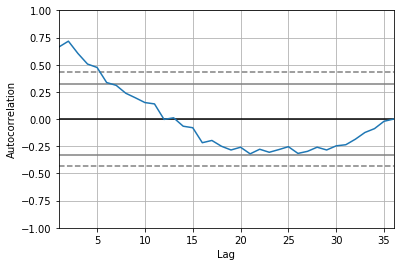

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.show()

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the AR parameter of the model may be 5.

## ARIMA

/Users/omerovenc/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/omerovenc/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/omerovenc/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Fri, 02 Mar 2018   AIC                            406.340
Time:                        12:41:21   BIC                            417.227
Sample:                    02-01-2000   HQIC                           410.098
                         - 12-01-2002                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

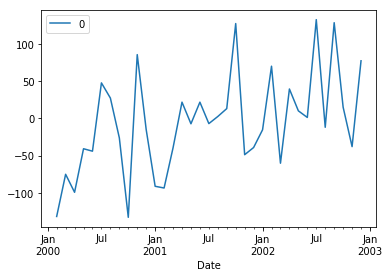

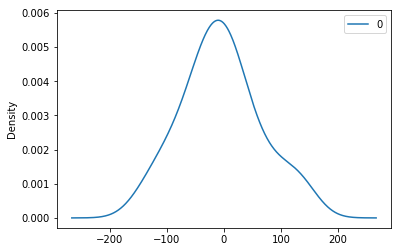

                0
count   35.000000
mean    -5.495146
std     68.132886
min   -133.296546
25%    -42.477844
50%     -7.186472
75%     24.748418
max    133.238028


In [34]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

Note, that although above we used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

## Rolling Forecast ARIMA Model

The ARIMA model can be used to forecast future time steps.

We can use the predict() function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction.

We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’.

Alternately, we can avoid all of these specifications by using the forecast() function, which performs a one-step forecast using the model.

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

Putting this all together, below is an example of a rolling forecast with the ARIMA model in Python.

/Users/omerovenc/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/omerovenc/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/omerovenc/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=349.117731, expected=342.300000
predicted=306.512967, expected=339.700000
predicted=387.376463, expected=440.400000
predicted=348.154190, expected=315.900000
predicted=386.308843, expected=439.300000
predicted=356.081977, expected=401.300000
predicted=446.379476, expected=437.400000
predicted=394.737342, expected=575.500000
predicted=434.915491, expected=407.600000
predicted=507.923414, expected=682.000000
predicted=435.482889, expected=475.300000
predicted=652.743781, expected=581.300000
predicted=546.343550, expected=646.900000
Test MSE: 6958.323


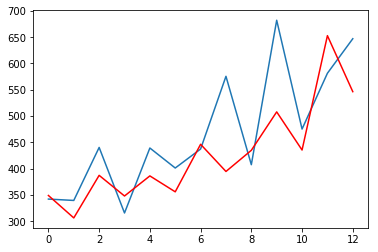

In [35]:
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Configuring an ARIMA Model
The classical approach for fitting an ARIMA model is to follow the Box-Jenkins Methodology.

This is a process that uses time series analysis and diagnostics to discover good parameters for the ARIMA model.

In summary, the steps of this process are as follows:

Model Identification. Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.
Parameter Estimation. Use a fitting procedure to find the coefficients of the regression model.
Model Checking. Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.
The process is repeated until either a desirable level of fit is achieved on the in-sample or out-of-sample observations (e.g. training or test datasets).

The process was described in the classic 1970 textbook on the topic titled Time Series Analysis: Forecasting and Control by George Box and Gwilym Jenkins. An updated 5th edition is now available if you are interested in going deeper into this type of model and methodology.

Given that the model can be fit efficiently on modest-sized time series datasets, grid searching parameters of the model can be a valuable approach.

I have a question:

– We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero mean.
What if the residuals are not normally distributed?

REPLY: It may mean that you could improve your model with some data transform, perhaps something like a boxcox?

## Atmospheric CO2 data set

In [36]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [37]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [40]:
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.425000
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
1959-11-01    314.875000
1959-12-01    315.525000
1960-01-01    316.380000
1960-02-01    316.975000
1960-03-01    317.575000
1960-04-01    319.120000
1960-05-01    319.925000
1960-06-01    319.450000
1960-07-01    318.060000
1960-08-01    315.775000
                 ...    
1999-07-01    369.000000
1999-08-01    366.700000
1999-09-01    364.675000
1999-10-01    365.140000
1999-11-01    366.650000
1999-12-01    367.900000
2000-01-01    369.020000
2000-02-01    369.375000
2000-03-01    370.400000


In [58]:
type(y)

pandas.core.series.Series

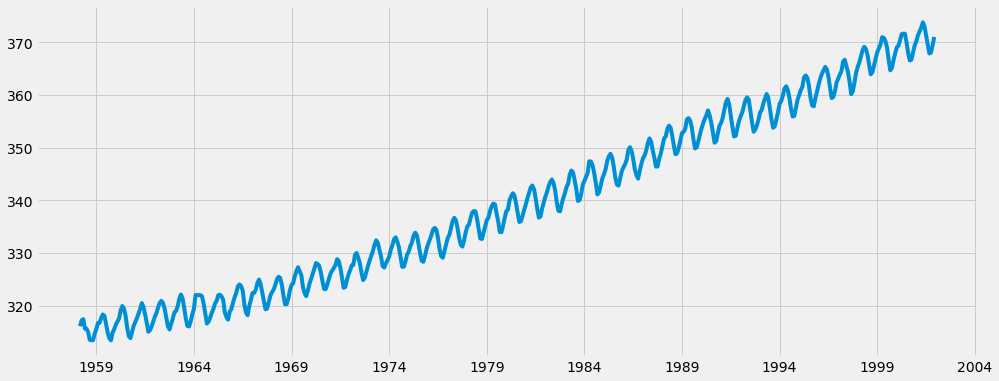

In [41]:
y.plot(figsize=(15, 6))
plt.show()

In [42]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [43]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624030462
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727641159
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.287842785377
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912937587
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.04875494035
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662328003615
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941066979707
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716809398
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1088.7022304116076
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.43094114512
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893619993
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912986582647
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194062
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:337.79385497181556
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:619.9501759055394
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:376.9283759666373
ARI

In [44]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


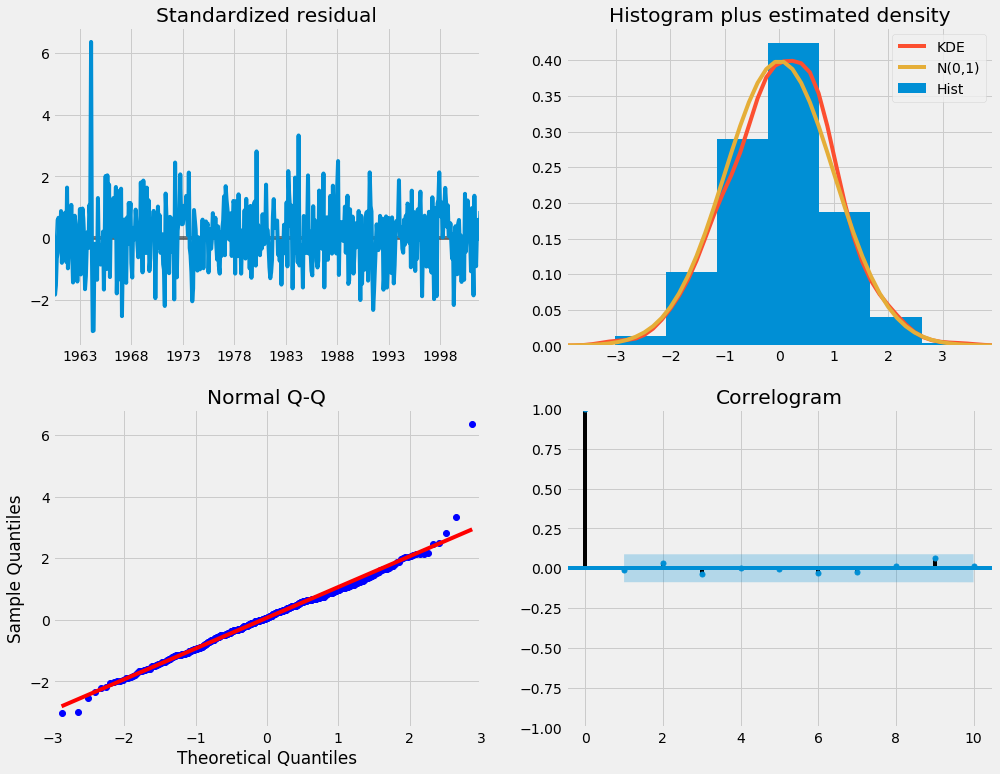

In [45]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [46]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [63]:
pred_ci

,lower co2,upper co2
2002-01-01,371.366718,372.588590
2002-02-01,372.005879,373.492311
2002-03-01,372.834952,374.489658
2002-04-01,373.963404,375.755835
2002-05-01,374.387755,376.303754
2002-06-01,373.753202,375.783991
2002-07-01,372.178424,374.317468
2002-08-01,370.101325,372.343287
2002-09-01,368.341911,370.682233
2002-10-01,368.503039,370.937740


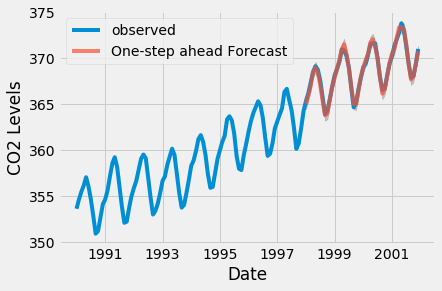

In [48]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [49]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [50]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

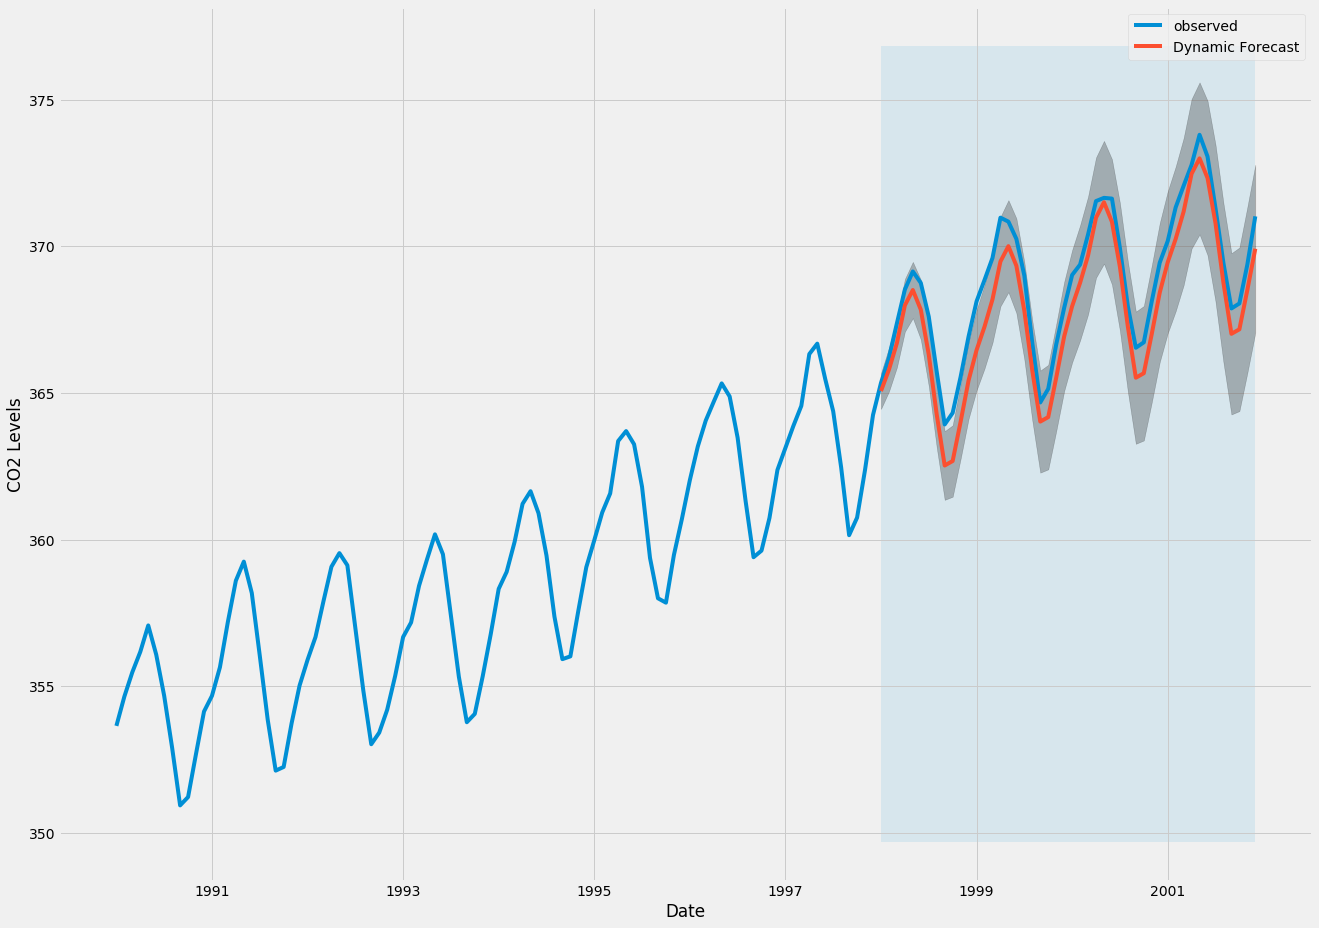

In [51]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [52]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


In [53]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

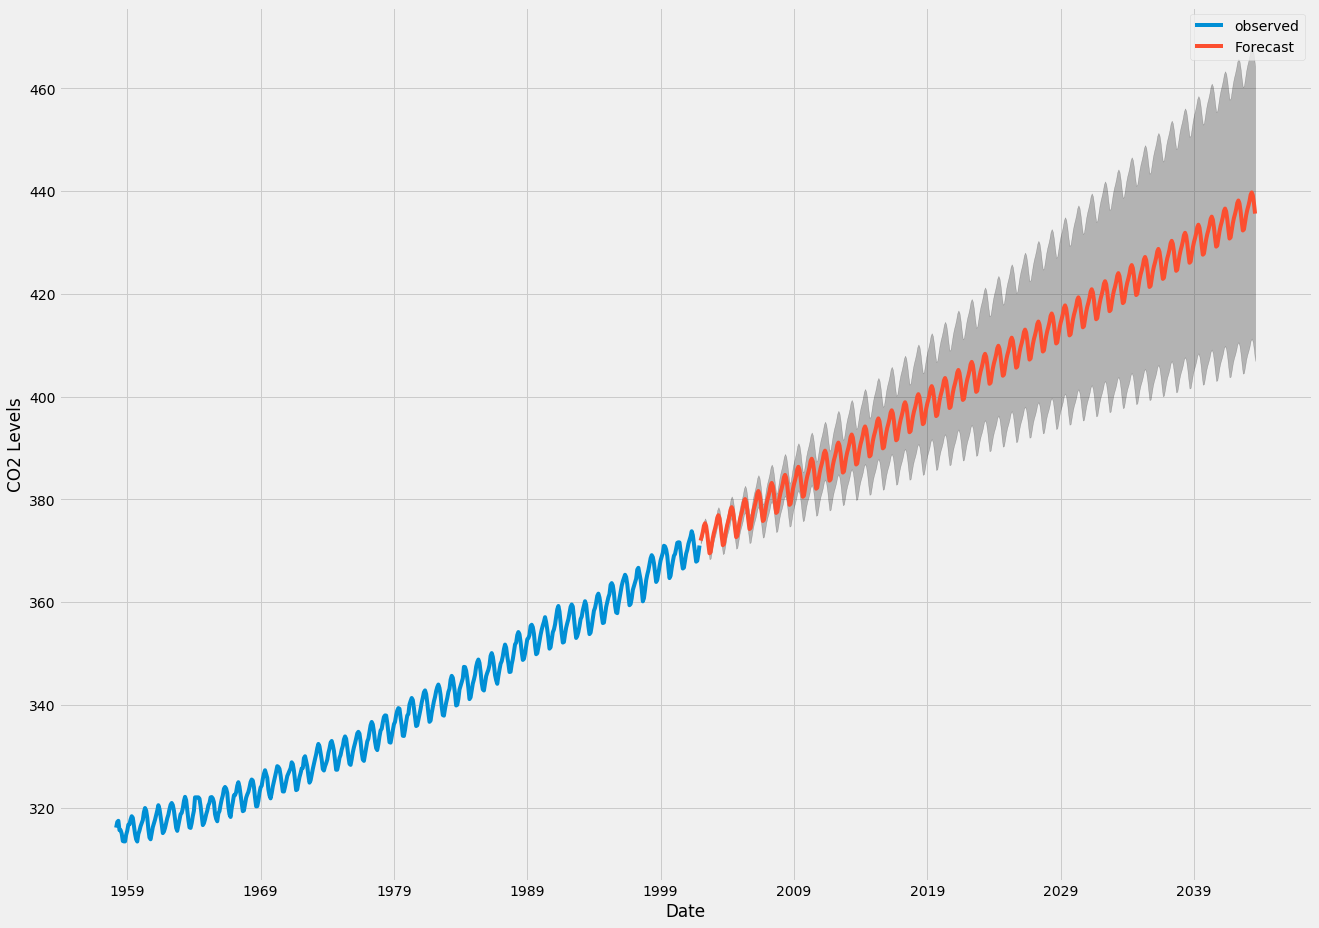

In [54]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()